In [1]:
#!/usr/bin/python
from __future__ import print_function
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from IPython.core.debugger import set_trace

In [2]:
from __future__ import print_function
import os, sys
import numpy as np
import warnings
import logging
from tqdm import tqdm
# Utils
from pathlib import Path
from easydict import EasyDict as edict
# DL framework
import tensorflow as tf
print('Tensorflow version: {}'.format(tf.__version__))
import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
from keras_applications.imagenet_utils import _obtain_input_shape

# Custom packages
user_dir = os.path.expanduser('~')
project_dir = Path(user_dir) / 'serviceBot'
sys.path.append("..")
from utils_dir.utils import timeit, get_varargin

# DEFINE
RESNET_FILTERS = edict()
RESNET_FILTERS.C2 = [64, 64, 256]
RESNET_FILTERS.C3 = [128, 128, 512]
RESNET_FILTERS.C4 = [256, 256, 1024]
RESNET_FILTERS.C5 = [512, 512, 2048]

Tensorflow version: 2.0.0


In [1]:
a=[1,1,2]
a*2

[1, 1, 2, 1, 1, 2]

In [14]:
print(os.path.abspath('..'))

/home/phatluu/serviceBot


In [3]:
def identity_block(x, **kwargs):
    """The identity block is the block that has no conv layer at shortcut.
    # Arguments
        input_tensor: input tensor
        kernel_size: defualt 3, the kernel size of middle conv layer at main path
        filters: list of integers, the filterss of 3 conv layer at main path
        stage: integer, current stage label, used for generating layer names
        block: 'a','b'..., current block label, used for generating layer names
    # Returns
        Output tensor for the block.
    """
    kernel_size = get_varargin(kwargs, 'kernel_size', 3)
    strides = get_varargin(kwargs, 'strides', (1,1))
    stage = get_varargin(kwargs, 'stage', 2)
    conv_block = get_varargin(kwargs, 'conv_block', False)
    block_name = get_varargin(kwargs, 'block_name', 'a')
    
    if stage == 2:
        filters = RESNET_FILTERS.C2
    elif stage == 3:
        filters = RESNET_FILTERS.C3
    elif stage == 4:
        filters = RESNET_FILTERS.C4
    else:
        filters = RESNET_FILTERS.C5    
       
    filters1, filters2, filters3 = filters
    bn_axis = 3 # Channel last, tensorflow backend
        
    fx = layers.Conv2D(filters1, (1, 1), strides = strides, name = 'C{}_b2{}_Conv1'.format(stage,block_name))(x)
    fx = layers.BatchNormalization(axis=bn_axis, name = 'C{}_b2{}_bn1'.format(stage, block_name))(fx) #bn: batchnorm
    fx = layers.Activation('relu')(fx)

    fx = layers.Conv2D(filters2, kernel_size,padding='same', name = 'C{}_b2{}_Conv2'.format(stage, block_name))(fx)
    fx = layers.BatchNormalization(axis = bn_axis, name = 'C{}_b2{}_bn2'.format(stage, block_name))(fx)
    fx = layers.Activation('relu')(fx)

    fx = layers.Conv2D(filters3, (1, 1), name = 'C{}_b2{}_Conv3'.format(stage, block_name))(fx)
    fx = layers.BatchNormalization(axis=bn_axis, name = 'C{}_b2{}_bn3'.format(stage, block_name))(fx)
    
    #Shortcut branch     
    if conv_block is True:
        shortcut = layers.Conv2D(filters3, (1, 1), strides = strides,
                         name = 'C{}_b1{}_Conv1'.format(stage, block_name))(x)
        shortcut = layers.BatchNormalization(axis=bn_axis, name = 'C{}_b1{}_bn1'.format(stage, block_name))(shortcut)
        
    else:
        shortcut = x
        
#   Merge
    fx = layers.Add()([fx, shortcut])
    fx = layers.Activation('relu')(fx)
    return fx

# Resnet50

In [4]:
def ResNet50(include_top=True,
             input_tensor=None, input_shape=None,
             pooling=None,
             classes=1000, **kwargs):
    """Instantiates the ResNet50 architecture.
    # Arguments       
    # Returns
        A Keras model instance.
    """
    include_top = get_varargin(kwargs, 'include_top', True)
    
    nb_classes = get_varargin(kwargs, 'nb_classes', 1000)
    
    # Determine proper input shape
    input_shape = _obtain_input_shape(input_shape,
                                      default_size=224,
                                      min_size=197,
                                      data_format=K.image_data_format(),
                                      require_flatten=include_top)

    if input_tensor is None:
        img_input = layers.Input(shape=input_shape)
    else:
        if not K.is_keras_tensor(input_tensor):
            img_input = layers.Input(tensor=input_tensor, shape=input_shape)
        else:
            img_input = input_tensor
    if K.image_data_format() == 'channels_last':
        bn_axis = 3
    else:
        bn_axis = 1

    x = layers.ZeroPadding2D((3, 3))(img_input)
    x = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1')(x)
    x = layers.BatchNormalization(axis=bn_axis, name='bn_conv1')(x)
    x = layers.Activation('relu')(x)
    x = layers.MaxPooling2D((3, 3), strides=(2, 2))(x)
    
    x = identity_block(x, stage = 2, block_name = 'a', conv_block = True)
    x = identity_block(x, stage = 2, block_name = 'b')
    x = identity_block(x, stage = 2, block_name = 'c')
    
    x = identity_block(x, stage = 3, block_name = 'a', conv_block = True, strides = (2,2))
    x = identity_block(x, stage = 3, block_name = 'b')
    x = identity_block(x, stage = 3, block_name = 'c')
    x = identity_block(x, stage = 3, block_name = 'd')

    x = identity_block(x, stage = 4, block_name = 'a', conv_block = True, strides = (2,2))
    x = identity_block(x, stage = 4, block_name = 'b')
    x = identity_block(x, stage = 4, block_name = 'c')
    x = identity_block(x, stage = 4, block_name = 'd')
    x = identity_block(x, stage = 4, block_name = 'e')
    x = identity_block(x, stage = 4, block_name = 'f')

    x = identity_block(x, stage = 5, block_name = 'a', conv_block = True, strides = (2,2))
    x = identity_block(x, stage = 5, block_name = 'b', )
    x = identity_block(x, stage = 5, block_name = 'c')

    x = layers.AveragePooling2D((7, 7), name='avg_pool')(x)

    if include_top:
        x = layers.Flatten()(x)
        x = layers.Dense(classes, activation='softmax', name='fc1000')(x)
    else:
        if pooling == 'avg':
            x = layers.GlobalAveragePooling2D()(x)
        elif pooling == 'max':
            x = layers.GlobalMaxPooling2D()(x)

    # Ensure that the model takes into account
    # any potential predecessors of `input_tensor`.
    if input_tensor is not None:
        inputs = get_source_inputs(input_tensor)
    else:
        inputs = img_input
        
    # Create model.
    model = Model(inputs, x, name='resnet50')
    return model

model = ResNet50(include_top=True)

In [5]:
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [6]:
from tensorflow.python.keras.utils.vis_utils import plot_model

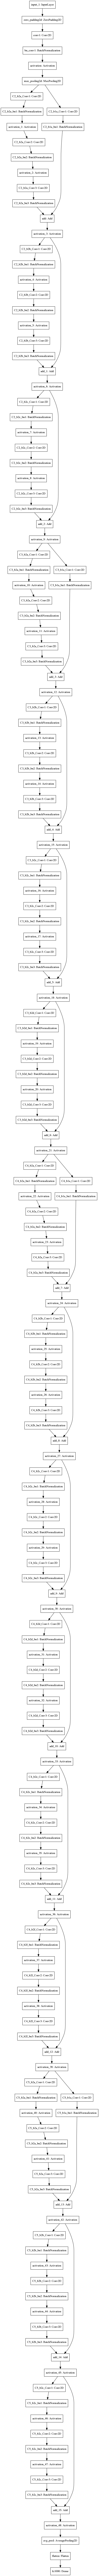

In [9]:
plot_model(model, to_file = 'resnet50.png')

In [11]:
import yaml

In [12]:
yaml.__version__

'5.1.2'